In [1]:
# import the necessary packages
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
!pip install imutils
import imutils
import cv2
import csv
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Arrow
import time
import os
import copy
!pip install pytorchvis
from pytorchvis.visualize_layers import VisualizeLayers
from PIL import Image as PImage
import io
import math
import pandas as pd

In [27]:
# run on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Path to Volume.csv with target volumes
volume = pd.read_csv('/content/drive/dataBall_VOLUME.csv')
volume.describe()
list_volume = volume['volume cm3'].tolist()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True).to(device)

In [18]:
# Path to the sphere image
IX_path = '/content/drive/ball_big.jpg'
row_list = [["scale ratio", "volume cm3", "sensors_x", "sensors_y", "sensors_e", "coordinates_src", "coordinates_dst"]]


normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize([224, 224]),
   transforms.ToTensor(),
   normalize
])
reshapeArray = np.array([224.0, 224.0])
IX = plt.imread(IX_path)
IX = cv2.resize(IX, (616, 616))

IX_trand = preprocess(PImage.fromarray(IX))
IX_trand.unsqueeze_(0)

sizeX = IX.shape[1]
sizeY = IX.shape[0]
camScale = np.array(IX.shape[:2]) / reshapeArray
camScale = camScale[::-1]

## Utils

In [0]:
def pairwise_distance(X, Y):
    assert len(X.shape) == len(Y.shape)
    N = X.shape[0]
    M = Y.shape[0]
    # D = len(X.shape)
    res = np.zeros([M, N])
    for i in range(M):
        for j in range(N):
            res[i][j] = np.linalg.norm(X[j] - Y[i])
    return res

def match(PD):
    seq = np.arange(PD.shape[0]) # create array of a certain shape from 0 to len
    amin1 = np.argmin(PD, axis=1) # return smallest index from each list
    C = np.array([seq, amin1]).transpose()
    min1 = PD[seq, amin1] # array of the minimum distances
    mask = np.zeros_like(PD) # return an array of zeros of the same shape as DP
    mask[seq, amin1] = 1
    masked = np.ma.masked_array(PD, mask) # PD without the smallest values
    min2 = np.amin(masked, axis=1) # return smallest num in list
    return C, np.array(min2/min1)

def match_max(PD):
    seq = np.arange(PD.shape[0])
    amax1 = np.argmin(PD, axis=1)
    C = np.array([seq, amax1]).transpose()
    return C

## Main loop


features_container_Sequential
	 features.0_conv_Conv2d
	 features.1_activation_ReLU
	 features.2_conv_Conv2d
	 features.3_activation_ReLU
	 features.4_pooling_MaxPool2d
	 features.5_conv_Conv2d
	 features.6_activation_ReLU
	 features.7_conv_Conv2d
	 features.8_activation_ReLU
	 features.9_pooling_MaxPool2d
	 features.10_conv_Conv2d
	 features.11_activation_ReLU
	 features.12_conv_Conv2d
	 features.13_activation_ReLU
	 features.14_conv_Conv2d
	 features.15_activation_ReLU
	 features.16_pooling_MaxPool2d
	 features.17_conv_Conv2d
	 features.18_activation_ReLU
	 features.19_conv_Conv2d
	 features.20_activation_ReLU
	 features.21_conv_Conv2d
	 features.22_activation_ReLU
	 features.23_pooling_MaxPool2d
	 features.24_conv_Conv2d
	 features.25_activation_ReLU
	 features.26_conv_Conv2d
	 features.27_activation_ReLU
	 features.28_conv_Conv2d
	 features.29_activation_ReLU
	 features.30_pooling_MaxPool2d
avgpool_pooling_AdaptiveAvgPool2d
classifier_container_Sequential
	 classifier.0_linear_Line

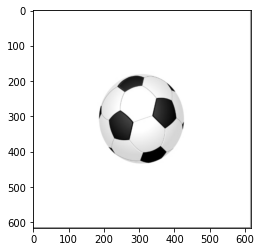

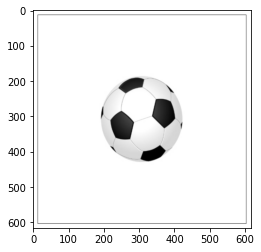

In [12]:
index = 0
for j in range(100, 2, -1):
    scaling_ratio = j / 100
    width = int(sizeX * scaling_ratio)
    height = int(sizeY * scaling_ratio)

    dsize = (width, height)
    rescale = cv2.resize(IX, dsize)
    full_rescale = np.full([sizeY, sizeX, 3], 255, dtype=np.uint8)
    padding = IX.shape[0]//2 - rescale.shape[0]//2
    full_rescale[padding:rescale.shape[0]+padding, padding:rescale.shape[0]+padding, :] = rescale

    IY_trand = preprocess(PImage.fromarray(full_rescale))
    IY_trand.unsqueeze_(0)
    cnn_input = torch.cat((IX_trand, IY_trand), dim=0)
    vis = VisualizeLayers(model,layers='all')
    output = model(cnn_input.to(device))
    # get the intermediate layers output which was passed d  uring initialization
    interm_output = vis.get_interm_output()
    features_pool3 = interm_output['features.16_pooling_MaxPool2d'].cpu()

    featureMap = []
    DY1 = np.zeros(shape=(784,256))
    pool3_flat = np.reshape(features_pool3[1], [-1, 784]).numpy()
    for i in range(pool3_flat.shape[1]):
        for kernel in pool3_flat:
            featureMap.append(kernel[i])
        DY1[i] = featureMap
        featureMap = []

    DX1 = np.zeros(shape=(784,256))
    pool3_flat = np.reshape(features_pool3[0], [-1, 784]).numpy()
    for i in range(pool3_flat.shape[1]):
        for kernel in pool3_flat:
            featureMap.append(kernel[i])
        DX1[i] = featureMap
        featureMap = []

    DX1, DY1 = DX1 / np.std(DX1), DY1 / np.std(DY1)
    PD1 = pairwise_distance(DX1, DY1)
    seq = np.array([[i, j] for i in range(28)
                for j in range(28)], dtype='int32')

    X = np.array(seq, dtype='float32') * 8.0 + 4.0
    Y = np.array(seq, dtype='float32') * 8.0 + 4.0

    # prematch and select points
    C_all, quality = match(PD1)
    theta_max = np.max(quality) # large starting threshold that only confident inliers satisfy
    while np.where(quality >= theta_max)[0].shape[0] <= 50:
        theta_max -= 0.01
    C = C_all[np.where(quality >= theta_max)]
    X, Y = X[C[:, 1]], Y[C[:, 0]]
    num_matches = C.shape[0]
    Xscaled = X* camScale
    Yscaled = Y* camScale

    difference_listX = []
    difference_listY = []
    euclideanDistance_list = []

    coordinatesSRC = []
    coordinatesDST = []

    for i, pnt in enumerate(Xscaled):
        src_x = int(pnt[1])
        src_y = int(pnt[0])
        dst_x = int(Yscaled[i][1])
        dst_y = int(Yscaled[i][0])

        difference_listX.append(src_x - dst_x)
        difference_listY.append(src_y - dst_y)
        euclideanDistance_list.append(dist.euclidean((src_x, src_y), (dst_x, dst_y)))
        coordinatesSRC.append(src_x/sizeX)
        coordinatesSRC.append(src_y/sizeY)
        coordinatesDST.append(dst_x/sizeX)
        coordinatesDST.append(dst_y/sizeY)

    volume_el = list_volume[index]
    index +=1

    row_list.append([scaling_ratio, volume_el, difference_listX, difference_listY, euclideanDistance_list, coordinatesSRC, coordinatesDST])

plt.imshow(full_rescale)
plt.show()

## Create the CSV file

In [0]:
with open('dataBall_deepFeatures.csv', 'w', newline='') as myfile:
    writer = csv.writer(myfile, quoting=csv.QUOTE_NONNUMERIC, delimiter=',')
    writer.writerows(row_list)
